In [1]:
import re 
import tqdm
import pickle
import collections
import itertools
import tables

import glob
from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import sys
sys.path.insert(0, '../')
from __init__jupyterlab import *
import utils
import enhancer_gene_utils 

In [2]:
import datetime
today = datetime.date.today().strftime("%y%m%d")

CORRCOEF_TYPE = 'Spearmanr' # Pearsonr
print(today)

211116


In [3]:
resolution = 10
fname1 = glob.glob('./results/mop_rna_mc_ka30_knn30_*_0_cluster_r10_spearmanr_corrs.pkl')[0]
fname2 = glob.glob('./results/mop_rna_atac_ka30_knn30_*_0_cluster_r10_spearmanr_corrs.pkl')[0]


output_results = './results/fig_{}_r{:.1f}_{{}}'.format(today, resolution)
print(output_results)



./results/fig_211116_r10.0_{}


# config

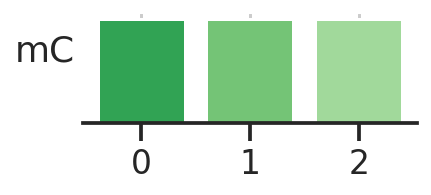

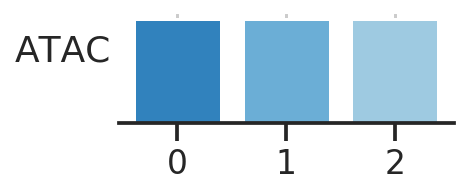

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


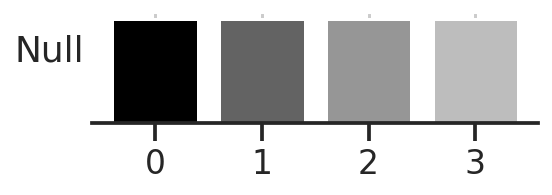

In [4]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()
    
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}

KB = 1000
def p25(x):
    return np.nanpercentile(x, 25)

def p75(x):
    return np.nanpercentile(x, 75)

def strip_gid_suffix(gid):
    """
    """
    if isinstance(gid, str):
        gid_new = gid.split('.')[0]
    else:
        gid_new = ''
    return gid_new

# data 

In [5]:
# genes
# enhs
# to_evals
f = './data/annot/genes_list.tsv'
genes_list = pd.read_csv(f, sep='\t', index_col=False)
print(genes_list.shape)

# enh list
f = './data/annot/enhs_list.tsv'
enh_list = pd.read_csv(f, sep='\t', index_col=False)
print(enh_list.shape)

# pair list
f = './data/annot/enhancer_gene_pairs.tsv' 
to_evals = pd.read_csv(f, sep='\t', index_col=False)
to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})

print(to_evals.shape)

(31053, 11)
(233514, 7)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2589994, 4)


<ipython-input-5-d6c7f22691ed>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})


In [6]:
gid_to_gname = genes_list.groupby('gid').first()['gene_name'] 
gname_to_gid = genes_list.groupby('gene_name').first()['gid']

def gname_to_gid_nan(name):
    try:
        return gname_to_gid[name]
    except:
        return np.nan

In [7]:
f = './data/annot/enhancer_nearest_genes.bed' 
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str}, 
                           names=['chr', 'start', 'end', 
                                  'trpt_chr', 'trpt_start', 'trpt_end', 
                                  'strand', 
                                  'trpt_id', 'trpt_name',
                                  'gene_id', 'gene_name',
                                  'dist',
                                 ]
                          )

print(regions_info.shape)
print(enh_list.shape)
# expand enh_list
enh_list_expand = pd.merge(enh_list, regions_info, on=['chr', 'start', 'end'], how='left')
print(enh_list_expand.shape)
enh_list_expand.head()

(233514, 12)
(233514, 7)
(233514, 16)


,index,chr,start,end,length,chrom,center,trpt_chr,trpt_start,trpt_end,strand,trpt_id,trpt_name,gene_id,gene_name,dist
0,0,chr1,3083769,3083816,47,1,3083792,chr1,3073253,3073254,+,ENSMUST00000193812.1,4933401J01Rik-201,ENSMUSG00000102693.1,4933401J01Rik,10516
1,1,chr1,3112234,3112467,233,1,3112350,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10218
2,2,chr1,3112770,3112986,216,1,3112878,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10754
3,3,chr1,3113717,3114035,318,1,3113876,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,11701
4,4,chr1,3118790,3118935,145,1,3118862,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,16774


# Analysis 

In [8]:
## organize data; get results
# get corrs
with open(fname1, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res_corrs = to_evals[to_correlate].copy()
res_corrs['corr'] = corrs 
res_corrs['corr_shuff'] = corrs_shuffled
res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

print(res_corrs.shape)
res_corrs.head()

(2340530, 7)


,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,0.098290,-0.062836,-0.058660
1,ENSMUSG00000000001,147522,985740,False,0.139134,-0.133476,-0.200592
2,ENSMUSG00000000001,147523,983725,False,-0.058867,-0.046901,-0.077379
3,ENSMUSG00000000001,147527,970444,False,0.295639,-0.023887,-0.076905
4,ENSMUSG00000000001,147528,969372,False,-0.242118,0.120000,0.023947


In [9]:
with open(fname2, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res2_corrs = to_evals[to_correlate].copy()
res2_corrs['corr'] = corrs 
res2_corrs['corr_shuff'] = corrs_shuffled
res2_corrs['corr_shuff_cells'] = corrs_shuffled_cells

print(res_corrs.shape)
res_corrs.head()

(2340530, 7)


,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,0.098290,-0.062836,-0.058660
1,ENSMUSG00000000001,147522,985740,False,0.139134,-0.133476,-0.200592
2,ENSMUSG00000000001,147523,983725,False,-0.058867,-0.046901,-0.077379
3,ENSMUSG00000000001,147527,970444,False,0.295639,-0.023887,-0.076905
4,ENSMUSG00000000001,147528,969372,False,-0.242118,0.120000,0.023947


In [10]:
# mean pattern
n = 100
_dists = np.linspace(2*KB, 1000*KB, n)
res_corrs_median = res_corrs.groupby(pd.cut(res_corrs['dist'], _dists)).agg([np.median, 
                                                                             np.mean, 
                                                                             p25,
                                                                             p75,
                                                                            ])
res2_corrs_median = res2_corrs.groupby(pd.cut(res2_corrs['dist'], _dists)).agg([np.median, 
                                                                             np.mean, 
                                                                             p25,
                                                                             p75,
                                                                            ])

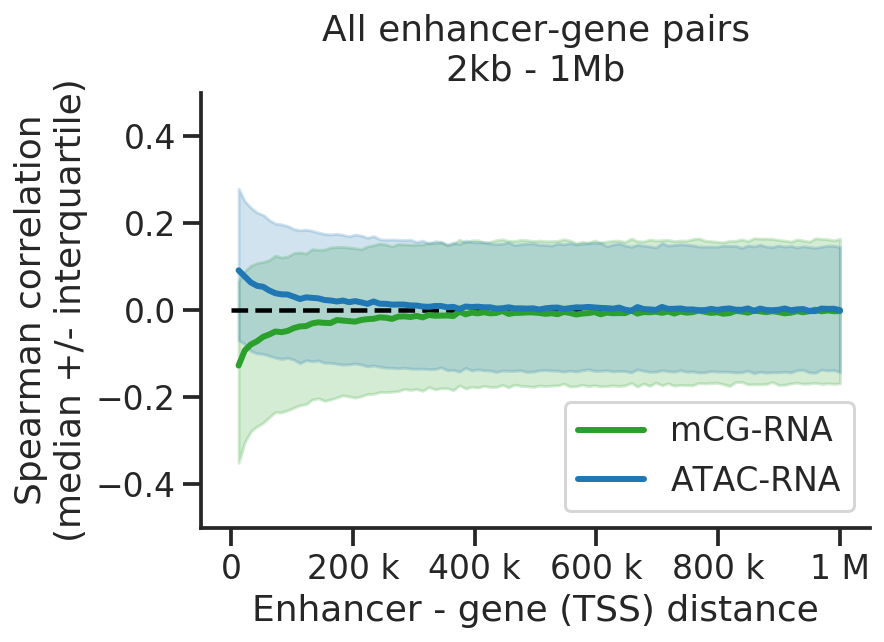

In [11]:
fig, ax = plt.subplots(figsize=(6,4))

_x = _dists[1:]
ax.hlines(0, 0, np.max(_x), linestyle='--')

_y = res_corrs_median['corr']['median'].values
_ylow = res_corrs_median['corr']['p25'].values
_yhigh = res_corrs_median['corr']['p75'].values
ax.plot(_x, _y, 
        label='mCG-RNA',
        linewidth=3,
        color=mod_palette['mc'])
ax.fill_between(_x, _ylow, _yhigh, color=mod_palette['mc'], alpha=0.2, 
#                 label='mCG interquartile',
               )
sns.despine(ax=ax)

_y = res2_corrs_median['corr']['median'].values
_ylow = res2_corrs_median['corr']['p25'].values
_yhigh = res2_corrs_median['corr']['p75'].values
ax.plot(_x, _y, 
        label='ATAC-RNA',
        linewidth=3,
        color=mod_palette['atac'])
ax.fill_between(_x, _ylow, _yhigh, color=mod_palette['atac'], alpha=0.2, 
#                 label='ATAC interquartile',
               )
sns.despine(ax=ax)
ax.grid(False)

ax.set_title('All enhancer-gene pairs\n2kb - 1Mb')
ax.set_ylabel('Spearman correlation\n(median +/- interquartile)')
ax.set_xlabel('Enhancer - gene (TSS) distance')
# ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.legend(bbox_to_anchor=(1,0), loc='lower right')
ax.xaxis.set_major_formatter(mtick.EngFormatter())
ax.set_ylim([-0.5, 0.5])

# fig.savefig(output_figures.format('line_corr_dist.pdf'), bbox_inches='tight')
plt.show()

### Statistical evaluation 

In [12]:
fdr = 0.2
dist_th = 1e5 # 100kb
# pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
nbins = 501

res_stats = enhancer_gene_utils.get_significance_stats(
                            res_corrs[['gene', 'enh', 'dist']],
                            res_corrs['corr'],
                            res_corrs['corr_shuff'],
                            res_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=False,
                            return_pval=True,
                            return_cdf=False,
                        )
res2_stats = enhancer_gene_utils.get_significance_stats(
                            res2_corrs[['gene', 'enh', 'dist']],
                            res2_corrs['corr'],
                            res2_corrs['corr_shuff'],
                            res2_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=True,
                            return_pval=True,
                            return_cdf=False,
                        )
print(list(res_stats.keys()))
print(list(res2_stats.keys()))

['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']
['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']


In [13]:
# save some results
output = output_results.format('linked_pairs_mc.tsv')
print(output)
res_stats['linked_table'].to_csv(output, sep="\t", header=True, index=False)
output = output_results.format('linked_pairs_atac.tsv')
res2_stats['linked_table'].to_csv(output, sep="\t", header=True, index=False)

output = output_results.format('correlated_pairs_mc.tsv')
print(output)
res_stats['correlated_table'].to_csv(output, sep="\t", header=True, index=False)
output = output_results.format('correlated_pairs_atac.tsv')
res2_stats['correlated_table'].to_csv(output, sep="\t", header=True, index=False)

./results/fig_211116_r10.0_linked_pairs_mc.tsv
./results/fig_211116_r10.0_correlated_pairs_mc.tsv


# Bar plots
- compare different sets

In [14]:
# annotate pairs
def yes_no_na(pair, pos_set, scope_set):
    """3 states = yes, no, NA = (1, 0, -1)
    """
#     assert pos_set.issubset(all_set)
    
    if pair not in scope_set:
        return -1
    return int(pair in pos_set)

# grand scope
sets = [
    set(res2_stats['linked_table'].index.values),
    set(res_stats['linked_table'].index.values),
    set(res2_stats['correlated_table'].index.values),
    set(res_stats['correlated_table'].index.values),
]
grand_scope = sets[0] | sets[1] | sets[2] | sets[3]

# correlated pos vs neg
# one track is one column
_tmp = pd.merge(res_stats['correlated_table'].reset_index(), 
                res_corrs, on=['gene', 'enh', 'dist'],
                how='left',
               )
_tmp2 = pd.merge(res2_stats['correlated_table'].reset_index(), 
                 res2_corrs, on=['gene', 'enh', 'dist'],
                 how='left',
                )

# get is_in_genebody, is_nearest_gene
df_nngene = res_stats['linked_table'].copy().reset_index()
df_nngene['mod'] = 'mc'
# add is_in_genebody
df_nngene = pd.merge(df_nngene, 
                     to_evals[['gene', 'enh', 'is_in_genebody']], 
                     on=['gene', 'enh'],
                     how='left')
# add is_nearest_gene
df_nngene['nearest_gene'] = (enh_list_expand.set_index('index')
                                            .reindex(df_nngene['enh'].values.astype(int))
                                            ['gene_id']
                                            .apply(strip_gid_suffix)
                                            .values
                            )
df_nngene['is_nearest_gene'] = (df_nngene['gene'] == df_nngene['nearest_gene'])

# summary
n_linked = len(df_nngene)
n_nngene = df_nngene['is_nearest_gene'].sum()
print("{}/{}={:.2f} pairs are from the nearest genes"
      .format(n_nngene, n_linked, n_nngene/n_linked))

# get is_in_genebody, is_nearest_gene,
df2_nngene = res2_stats['linked_table'].copy().reset_index()
df2_nngene['mod'] = 'atac'
# add is_in_genebody
df2_nngene = pd.merge(df2_nngene, 
                      to_evals[['gene', 'enh', 'is_in_genebody']], 
                      on=['gene', 'enh'],
                      how='left')
# add is_nearest_gene
df2_nngene['nearest_gene'] = (enh_list_expand.set_index('index')
                                             .reindex(df2_nngene['enh'].values.astype(int))
                                             ['gene_id']
                                             .apply(strip_gid_suffix)
                                             .values
                            )
df2_nngene['is_nearest_gene'] = (df2_nngene['gene'] == df2_nngene['nearest_gene'])

# summary
n_linked = len(df2_nngene)
n_nngene = df2_nngene['is_nearest_gene'].sum()
print("{}/{}={:.2f} pairs are from the nearest genes"
      .format(n_nngene, n_linked, n_nngene/n_linked))


# pairs_annot
pairs_annot = pd.DataFrame(index=grand_scope)

pairs_annot['ATAC_linked'] = [yes_no_na(pair, sets[0], grand_scope) for pair in pairs_annot.index]
pairs_annot['mCG_linked'] = [yes_no_na(pair, sets[1], grand_scope) for pair in pairs_annot.index]
pairs_annot['ATAC_correlated'] = [yes_no_na(pair, sets[2], grand_scope) for pair in pairs_annot.index]
pairs_annot['mCG_correlated'] = [yes_no_na(pair, sets[3], grand_scope) for pair in pairs_annot.index]

# among correlated mc
pos_set = set(_tmp[_tmp['corr']>0]['index'])
scope_set = set(_tmp['index'])
pairs_annot['correlated_mc_pos'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]
# among correlated atac
pos_set = set(_tmp2[_tmp2['corr']>0]['index'])
scope_set = set(_tmp2['index'])
pairs_annot['correlated_atac_pos'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

# among linked mc
pos_set = set(df_nngene['index'])
scope_set = grand_scope
pairs_annot['linked_mc'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

pos_set = set(df_nngene[df_nngene['is_in_genebody']]['index'])
scope_set = set(df_nngene['index'])
pairs_annot['linked_mc_is_in_genebody'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

pos_set = set(df_nngene[df_nngene['is_nearest_gene']]['index'])
scope_set = set(df_nngene['index'])
pairs_annot['linked_mc_is_nearest_gene'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

# among linked atac
pos_set = set(df2_nngene['index'])
scope_set = grand_scope
pairs_annot['linked_atac'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

pos_set = set(df2_nngene[df2_nngene['is_in_genebody']]['index'])
scope_set = set(df2_nngene['index'])
pairs_annot['linked_atac_is_in_genebody'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]

pos_set = set(df2_nngene[df2_nngene['is_nearest_gene']]['index'])
scope_set = set(df2_nngene['index'])
pairs_annot['linked_atac_is_nearest_gene'] = [yes_no_na(pair, pos_set, scope_set) for pair in pairs_annot.index]


print(pairs_annot.shape)
pairs_annot.head()

1335/2713=0.49 pairs are from the nearest genes
1148/2414=0.48 pairs are from the nearest genes
(133151, 12)


,ATAC_linked,mCG_linked,ATAC_correlated,mCG_correlated,correlated_mc_pos,correlated_atac_pos,linked_mc,linked_mc_is_in_genebody,linked_mc_is_nearest_gene,linked_atac,linked_atac_is_in_genebody,linked_atac_is_nearest_gene
2097156,0,0,0,1,0,-1,0,-1,-1,0,-1,-1
2097158,0,0,0,1,1,-1,0,-1,-1,0,-1,-1
2097159,0,0,0,1,1,-1,0,-1,-1,0,-1,-1
1048586,0,0,0,1,0,-1,0,-1,-1,0,-1,-1
1048587,0,0,0,1,1,-1,0,-1,-1,0,-1,-1


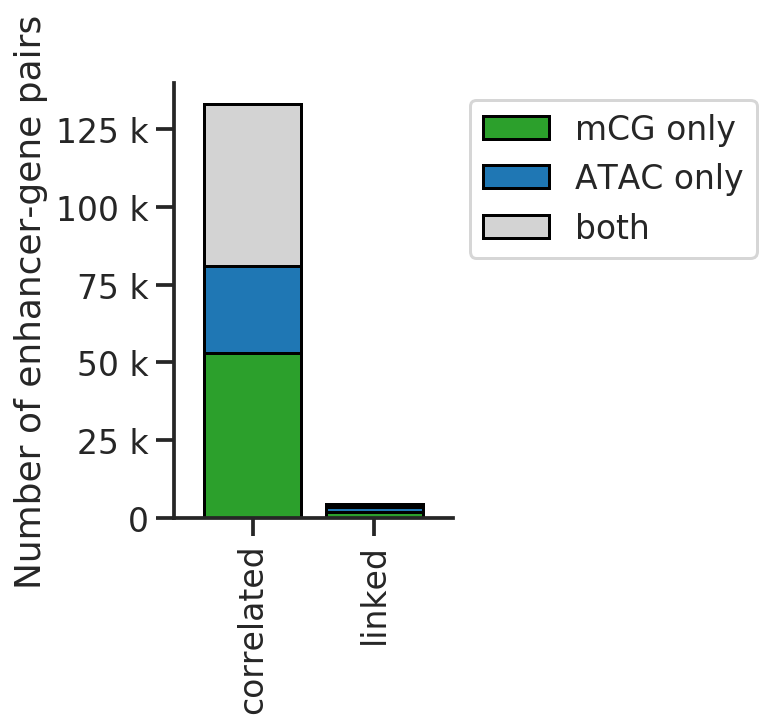

In [15]:
# output1 = output_figures.format('bar_pairs_linkedvscorrelated.pdf')
# output2 = output_figures.format('bar_pairs_linked.pdf')

df_col1 = pairs_annot.groupby(['ATAC_linked', 'mCG_linked']).size()
df_col1.index = df_col1.index.values
df_col2 = pairs_annot.groupby(['ATAC_correlated', 'mCG_correlated']).size()
df_col2.index = df_col2.index.values
df = pd.concat([df_col1, df_col2], axis=1).rename(columns={0:'linked', 1: 'correlated'}).fillna(0).astype(int)
df.index = df.index.values
rename_labels = {
    (0, 0): 'None',
    (0, 1): 'mCG only',
    (1, 0): 'ATAC only',
    (1, 1): 'both',
}
df = df.T.head().rename(columns=rename_labels)[['mCG only', 'ATAC only', 'both']].reindex(['correlated', 'linked'])
colors = [mod_palette['mc'], mod_palette['atac'], 'lightgray',]

with sns.axes_style({
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    
    fig, ax = plt.subplots(figsize=(2.5,4))
    df.plot.bar(stacked=True, width=0.8, color=colors, ax=ax)
    
    sns.despine(ax=ax)
    ax.yaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_ylabel('Number of enhancer-gene pairs')
    
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1,1))
    
#     snmcseq_utils.savefig(fig, output1)
    plt.show()
    

./results/fig_211116_r10.0_correlated_pairs_atac.tsv


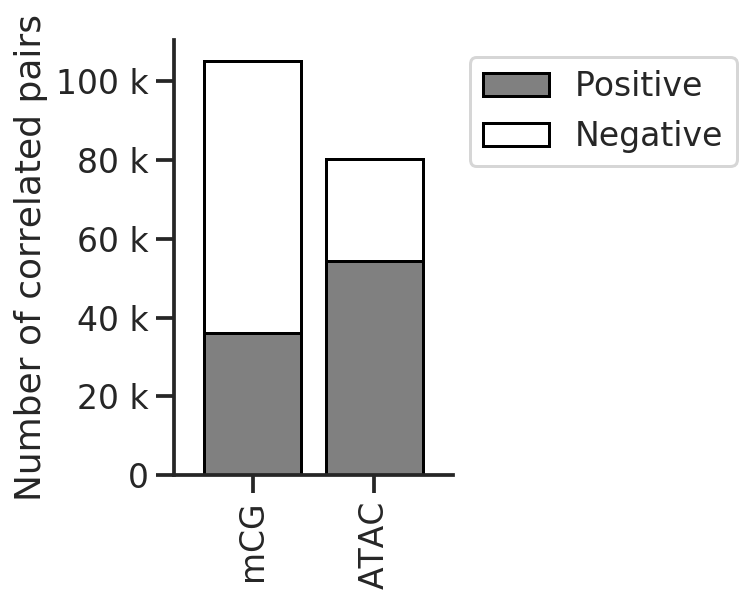

In [16]:
# output = output_figures.format('bar_frac_pos_neg.pdf')

df = pd.concat([
        pairs_annot.groupby(['correlated_mc_pos']).size(),
        pairs_annot.groupby(['correlated_atac_pos']).size(),
    ], axis=1).rename(columns={
        0: 'mCG', 
        1: 'ATAC',
}).fillna(0).astype(int)

df = df.T.rename(columns={0:'Negative', 1: 'Positive', -1: 'NA'})[['Positive', 'Negative',]]
colors = ['gray', 'white']

with sns.axes_style({
                     'patch.edgecolor': 'k',
                     'grid.linestyle': '',
                    }):
    
    fig, ax = plt.subplots(figsize=(2.5,4))
    df.plot.bar(stacked=True, width=0.8, color=colors, ax=ax)
    
    sns.despine(ax=ax)
    ax.yaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_ylabel('Number of correlated pairs')
    
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1,1))
    print(output)
#     snmcseq_utils.savefig(fig, output)
    

### Estimate frac tps
- Num significant (use the other code)

In [17]:
def estimate_frac_tps(pvalues, bin_n=100, frac_bin_null=0.20):
    """Use the median of the last 5% (frac_bin_null) of bins to estimate null level
    """
    y = np.sort(pvalues)
    bin_edges = np.linspace(0, 1, bin_n)
    bin_width = 1.0/bin_n
    
    bin_counts, bin_edges = np.histogram(y, bin_edges)
    y_norm = bin_counts/(bin_width*bin_counts.sum())
    null_level = np.median(y_norm[-int(frac_bin_null*bin_n):])
    frac_tp = np.clip(1 - null_level, 0, 1)
    
    return frac_tp, null_level, bin_counts, bin_edges, y_norm
    
def plot_pval_dist(ax, frac_tp, null_level, bin_counts, bin_edges, y_norm, fillcolor='C0'):
    _x = bin_edges[:-1]
    ax.plot(_x, y_norm, color='k')
    ax.plot([0, 1], [null_level]*2, linestyle='--', color='k')
    ax.fill_between(_x, null_level, y_norm, 
                    where=y_norm>null_level, alpha=1, color=fillcolor)
    ax.fill_between(_x, 0, np.minimum(y_norm, null_level), alpha=0.5, color='lightgray')
    ax.text(0, null_level+0.2*(1-null_level), 
            "{:.1f}%".format(frac_tp*100), 
            color='white',
            fontsize=18)
    sns.despine(ax=ax)
    return ax

def pipe_plot_pval_dist(ax, pvalues, bin_n=100, frac_bin_null=0.20, fillcolor='C0'):
    """
    """
    # fit distribution 
    frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(pvalues, bin_n=bin_n, frac_bin_null=frac_bin_null)
    # plot it out 
    plot_pval_dist(ax, 
                   frac_tp, null_level, bin_counts, bin_edges, y_norm, 
                   fillcolor=fillcolor,
                  )
    return 
    

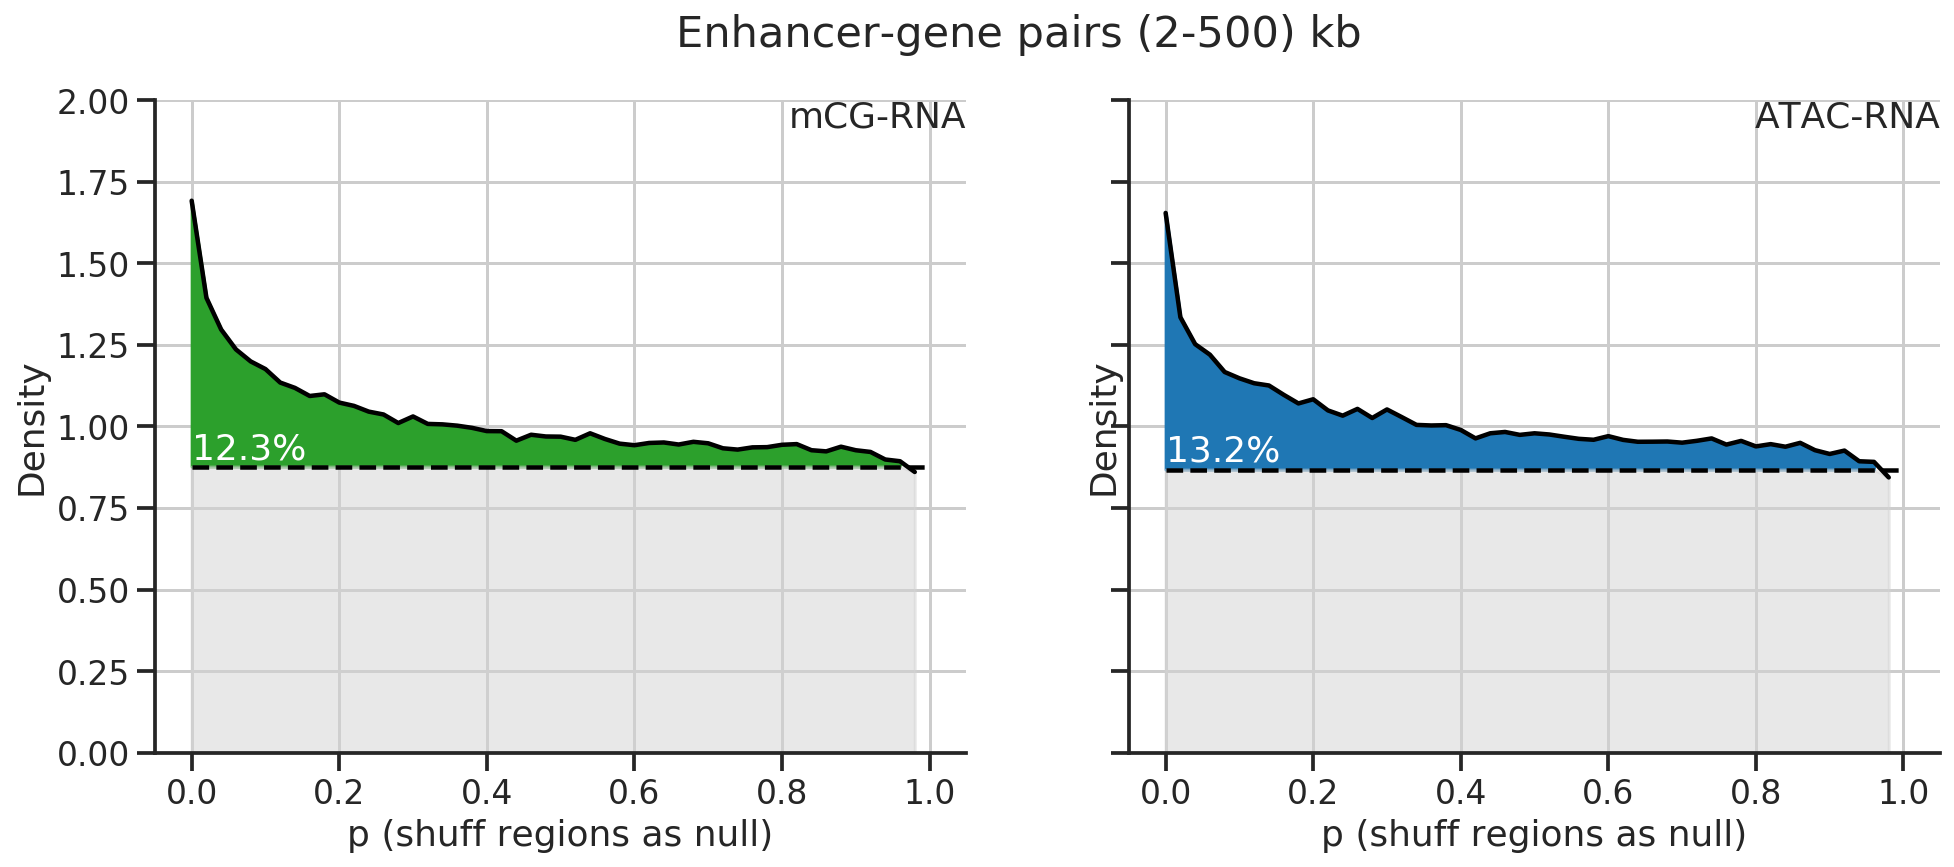

In [18]:
# plot pvalue distributions

ATAC_SIGN = -1
dist_th_this_plot = 5*1e5
bin_n = 51
frac_bin_null = 0.05

pvals = [
    np.interp(res_corrs[res_corrs['dist']<dist_th_this_plot]['corr'], res_stats['bins'][1:], res_stats['linked_pval']),
    np.interp(ATAC_SIGN*res2_corrs[res2_corrs['dist']<dist_th_this_plot]['corr'], res2_stats['bins'][1:], res2_stats['linked_pval']),
]
labels = ['mCG-RNA', 'ATAC-RNA']
colors = [mod_palette['mc'], mod_palette['atac']]

fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True, sharey=True)
for ax, pval, label, color in zip(axs, pvals, labels, colors):
    pipe_plot_pval_dist(ax, pval, bin_n=bin_n, frac_bin_null=frac_bin_null, fillcolor=color)
    ax.set_ylim([0, 2])
    ax.annotate(label, xy=(1,1), xycoords='axes fraction', ha='right', va='top')
    ax.set_xlabel('p (shuff regions as null)')
    ax.set_ylabel('Density')

fig.suptitle("Enhancer-gene pairs (2-500) kb")
# fig.savefig(output_figures.format('hist_pval_linked.pdf'), bbox_inches='tight')
plt.show()

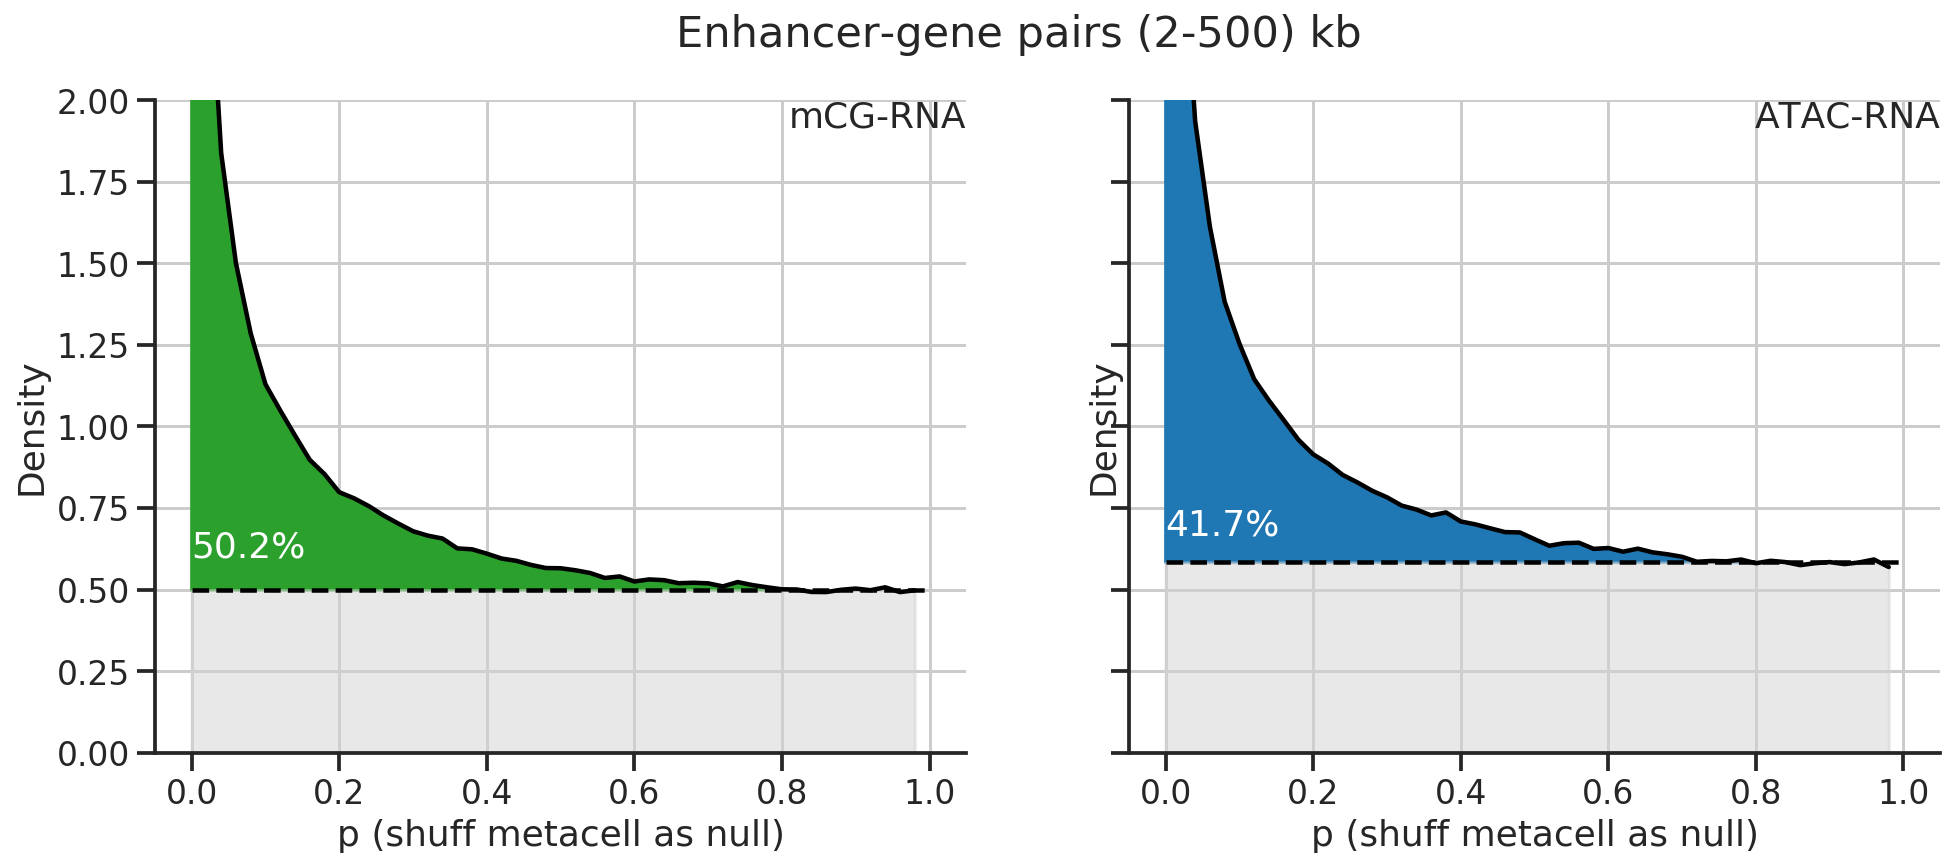

In [19]:
# plot pvalue distributions

ATAC_SIGN = -1
dist_th_this_plot = 5*1e5
bin_n = 51 
frac_bin_null = 0.1

pvals = [
    np.interp(res_corrs[res_corrs['dist']<dist_th_this_plot]['corr'], res_stats['bins'][1:], res_stats['correlated_pval']),
    np.interp(ATAC_SIGN*res2_corrs[res2_corrs['dist']<dist_th_this_plot]['corr'], res2_stats['bins'][1:], res2_stats['correlated_pval']),
]
labels = ['mCG-RNA', 'ATAC-RNA']
colors = [mod_palette['mc'], mod_palette['atac']]

fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True, sharey=True)
for ax, pval, label, color in zip(axs, pvals, labels, colors):
    pipe_plot_pval_dist(ax, pval, bin_n=bin_n, frac_bin_null=frac_bin_null, fillcolor=color)
    ax.set_ylim([0, 2])
    ax.annotate(label, xy=(1,1), xycoords='axes fraction', ha='right', va='top')
    ax.set_xlabel('p (shuff metacell as null)')
    ax.set_ylabel('Density')

fig.suptitle("Enhancer-gene pairs (2-500) kb")
# fig.savefig(output_figures.format('hist_pval_correlated.pdf'), bbox_inches='tight')
plt.show()

In [20]:
def quantile_norm(array):
    return pd.Series(array).rank(pct=True, method='average').values

def estimate_frac_tps_vs_dists(dists_kb, res_corrs, res_stats, link_type, FLIP_CORR_SIGN, 
                               bin_n=51, frac_bin_null=0.1,
                              ):
    """Estimate the fraction of true positives with many different distance segments
    """
    frac_tps = []
    num_tps = []
    total_nums = []
    for idx in np.arange(len(dists_kb)):
        dist_kb = dists_kb[idx]
        if idx == 0:
            cond = (res_corrs['dist'] < dist_kb*KB)
        else:
            dist_kb_prev = dists_kb[idx-1]
            cond = ((res_corrs['dist'] < dist_kb*KB) & 
                    (res_corrs['dist'] >= dist_kb_prev*KB))

        if FLIP_CORR_SIGN: 
            corr_sign = -1
        else:
            corr_sign = 1

        pval = np.interp(corr_sign*res_corrs[cond]['corr'], 
                                res_stats['bins'][1:], res_stats[link_type])
        frac_tp, null_level, bin_counts, bin_edges, y_norm = estimate_frac_tps(pval, bin_n=bin_n, frac_bin_null=frac_bin_null)
        frac_tps.append(frac_tp)
        total_nums.append(len(pval))
        num_tps.append(len(pval)*frac_tp)
    return dists_kb, frac_tps, num_tps, total_nums

def estimate_num_sigs_vs_dists(fdr_th, dists_kb, res_corrs, res_stats, link_type, FLIP_CORR_SIGN):
    """Estimate the number of significant pairs with many different distance segments
    """
    frac_tps = []
    num_tps = []
    total_nums = []
    
    sig_gene_set = set()
    cum_sig_genes = []
    
    for idx in np.arange(len(dists_kb)):
        dist_kb = dists_kb[idx]
        if idx == 0:
            cond = (res_corrs['dist'] < dist_kb*KB)
        else:
            dist_kb_prev = dists_kb[idx-1]
            cond = ((res_corrs['dist'] < dist_kb*KB) & 
                    (res_corrs['dist'] >= dist_kb_prev*KB))

        if FLIP_CORR_SIGN: 
            corr_sign = -1
        else:
            corr_sign = 1

        pval = np.interp(corr_sign*res_corrs[cond]['corr'], 
                                res_stats['bins'][1:], res_stats[link_type])
        fdr = pval/quantile_norm(pval)
        
        total_num = len(pval)
        total_nums.append(total_num)
        
        sig_cond = fdr<fdr_th
        sig_genes = res_corrs[cond][sig_cond]['gene']
        sig_gene_set = sig_gene_set.union(set(list(sig_genes.values)))
        cum_sig_gene = len(sig_gene_set)
        cum_sig_genes.append(cum_sig_gene)
        
        num_tp = sig_cond.sum()
        num_tps.append(num_tp)
        
        frac_tp = num_tp/total_num
        frac_tps.append(frac_tp)
        
        
    return dists_kb, frac_tps, num_tps, total_nums, cum_sig_genes

In [21]:
# calc
dist_begin_kb = 2
dist_binsize = 20
fdr_th = fdr
dists_kb = np.sort(np.hstack([np.arange(20, 500+1, dist_binsize),
#                               np.arange(4, 20, 2),
                   ]))
dists_kb_plot = np.hstack([[dist_begin_kb], dists_kb])


inputs = [
    (res_corrs, res_stats, 'linked_pval', False),
    (res2_corrs, res2_stats, 'linked_pval', True),
    (res_corrs, res_stats, 'correlated_pval', False),
    (res2_corrs, res2_stats, 'correlated_pval', True),
]
df_plots = []

bin_n = 51 # num bins in p level distribution
frac_bin_null = 0.1

for _input in inputs:
    
    _res_corrs, _res_stats, link_type, _flip = _input
    
#     if link_type == 'linked_pval':
#         bin_n = 51 # num bins in p level distribution
#         frac_bin_null = 0.05
#     elif link_type == 'correlated_pval':
#         bin_n = 51 # num bins in p level distribution
#         frac_bin_null = 0.1
    
    dists_kb, frac_tps, num_tps, total_nums = estimate_frac_tps_vs_dists(
            dists_kb, _res_corrs, _res_stats, 
            link_type,
            FLIP_CORR_SIGN=_flip, 
            bin_n=bin_n, frac_bin_null=frac_bin_null,)
    dists_kb, sig_frac_tps, sig_num_tps, sig_total_nums, cum_sig_genes = estimate_num_sigs_vs_dists(
            fdr_th, dists_kb, _res_corrs, _res_stats, 
            link_type,
            FLIP_CORR_SIGN=_flip)
    
    # organize results
    mats = np.vstack([
                dists_kb, 
                frac_tps, num_tps, total_nums,
                sig_frac_tps, sig_num_tps, sig_total_nums, cum_sig_genes,
                ]).T 
    cols = ['dist', 
            'frac_tp', 'num_pos', 'num_total', 
            'sig_frac_tp', 'sig_num_pos', 'sig_num_total', 'cum_sig_genes',
           ] 
    df_plot = pd.DataFrame(mats, columns=cols) 
#     df_plot['length'] = [dists_kb_plot[i+1] - dists_kb_plot[i] for i in range(len(dists_kb))]
#     df_plot['num_pos_norm'] = df_plot['num_pos']/df_plot['length']
#     df_plot['sig_num_pos_norm'] = df_plot['sig_num_pos']/df_plot['length']
    
    df_plots.append(df_plot)

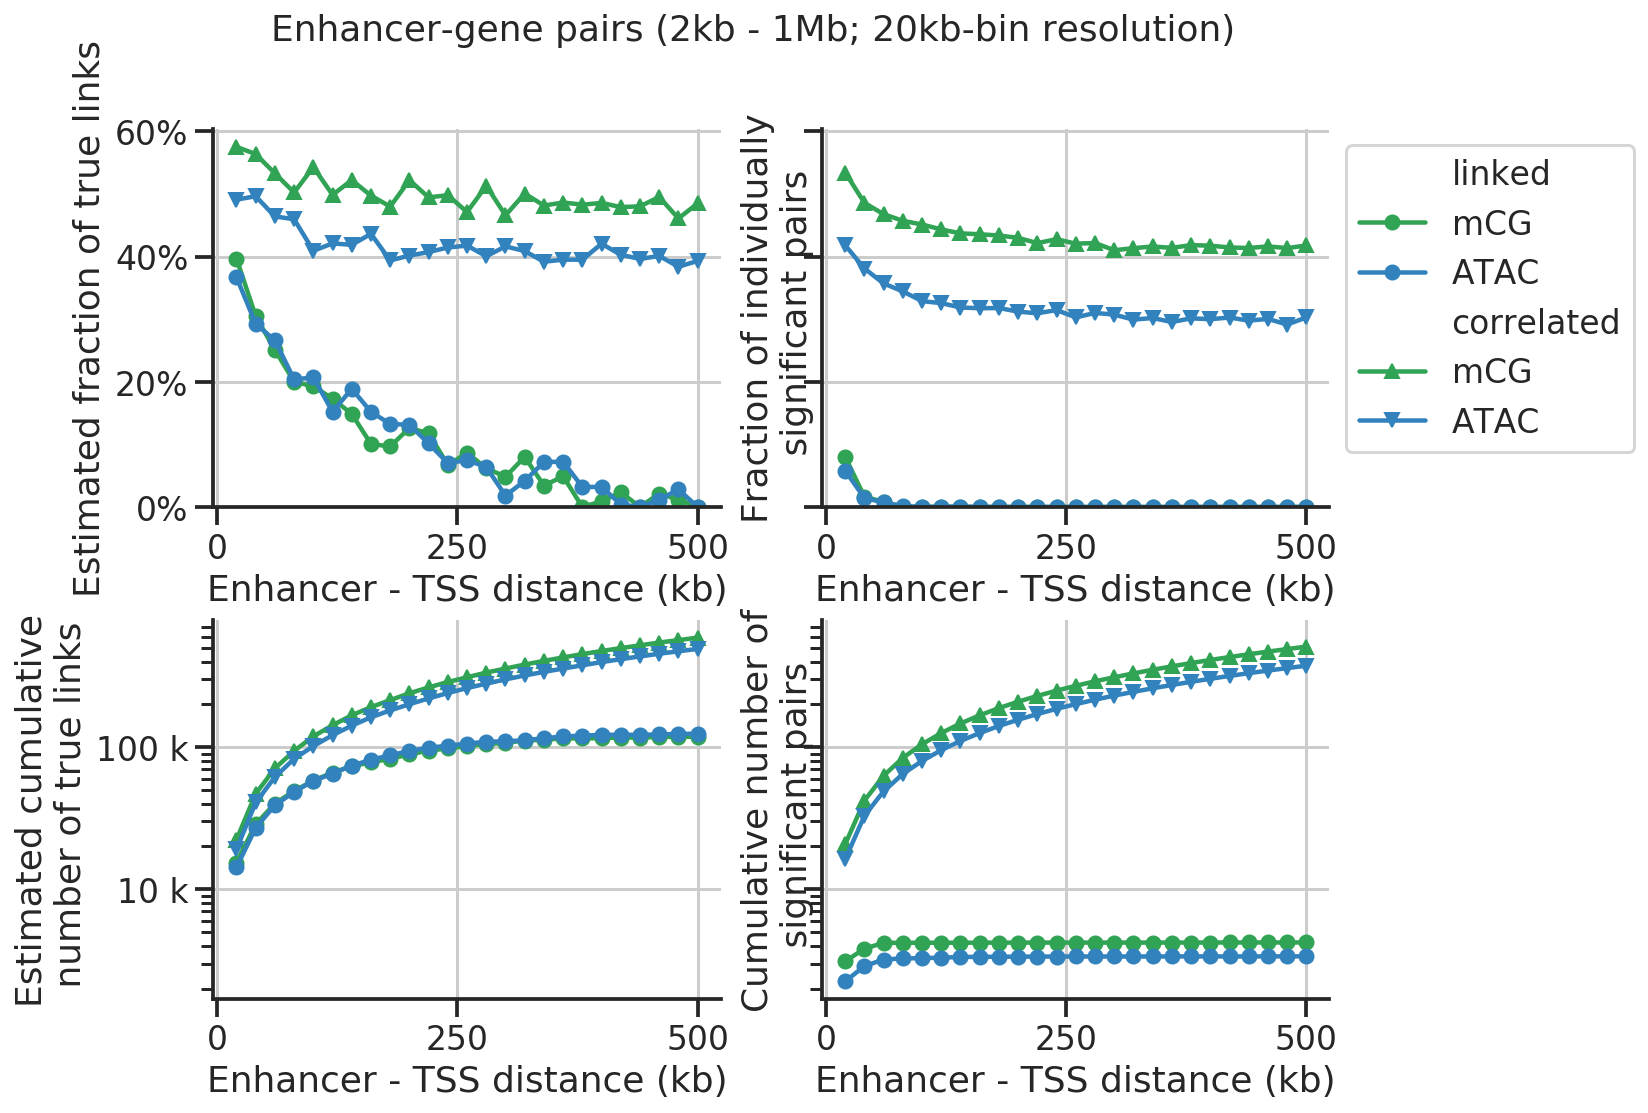

In [22]:
# prep

# one plot
colors = [
    mod_palette_comp['mc'][0], mod_palette_comp['atac'][0], 
    mod_palette_comp['mc'][0], mod_palette_comp['atac'][0], 
    ]
markers = ['o', 'o', '^', 'v']
labels = [
    'mCG linked', 'ATAC linked', 
    'mCG correlated', 'ATAC correlated', 
    ]

# all plots
subplot_cols = [
    'frac_tp', 
    'sig_frac_tp', 
    
    'num_pos',
    'sig_num_pos',
]
subplot_labels = [
    'Estimated fraction of true links', 
    'Fraction of individually\n significant pairs', 
    
    'Estimated cumulative\n number of true links',
    'Cumulative number of\n significant pairs',
    ]
tracks_all = [
    [(df_plot['dist'], df_plot[subplot_cols[0]]) for df_plot in df_plots],
    [(df_plot['dist'], df_plot[subplot_cols[1]]) for df_plot in df_plots],
    [(df_plot['dist'], np.cumsum(df_plot[subplot_cols[2]])) for df_plot in df_plots],
    [(df_plot['dist'], np.cumsum(df_plot[subplot_cols[3]])) for df_plot in df_plots],
]

# plot
fig, axs = plt.subplots(2, 2, figsize=(5*2,4*2), sharex=False, sharey='row')
r = EMPTY_RECTANGLE
for i, (ax, tracks_subplot, subplot_label) in enumerate(zip(
        axs.flat, tracks_all, subplot_labels)):
    for track, color, label, marker in zip(tracks_subplot, colors, labels, markers):
        _x, _y = track
        ax.plot(_x, _y, '-{}'.format(marker), color=color, label=label, markersize=7)
        
    sns.despine(ax=ax)
    ax.set_xlabel('Enhancer - TSS distance (kb)')
    ax.set_ylabel(subplot_label)
    ax.set_xticks([0, 250, 500])
    if i in [0, 1]:
        ax.set_ylim(ymin=0)
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 
    if i in [2, 3]:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(mtick.EngFormatter()) 
        

# work on legends
handles, labels = ax.get_legend_handles_labels()
labels = [label.split(' ')[0] for label in labels]
handles = [r] + handles[:2] + [r] + handles[2:]
labels = ['linked'] + labels[:2] + ['correlated'] + labels[2:]
axs.flat[1].legend(handles, labels, 
                      bbox_to_anchor=(1,1), loc='upper left', 
                     )
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle('Enhancer-gene pairs (2kb - 1Mb; {}kb-bin resolution)'.format(dist_binsize), 
             fontsize=18,
            )
# output = output_figures.format('plot_stats_vs_dist.pdf')
# print(output)
# fig.savefig(output, bbox_inches='tight')
plt.show()

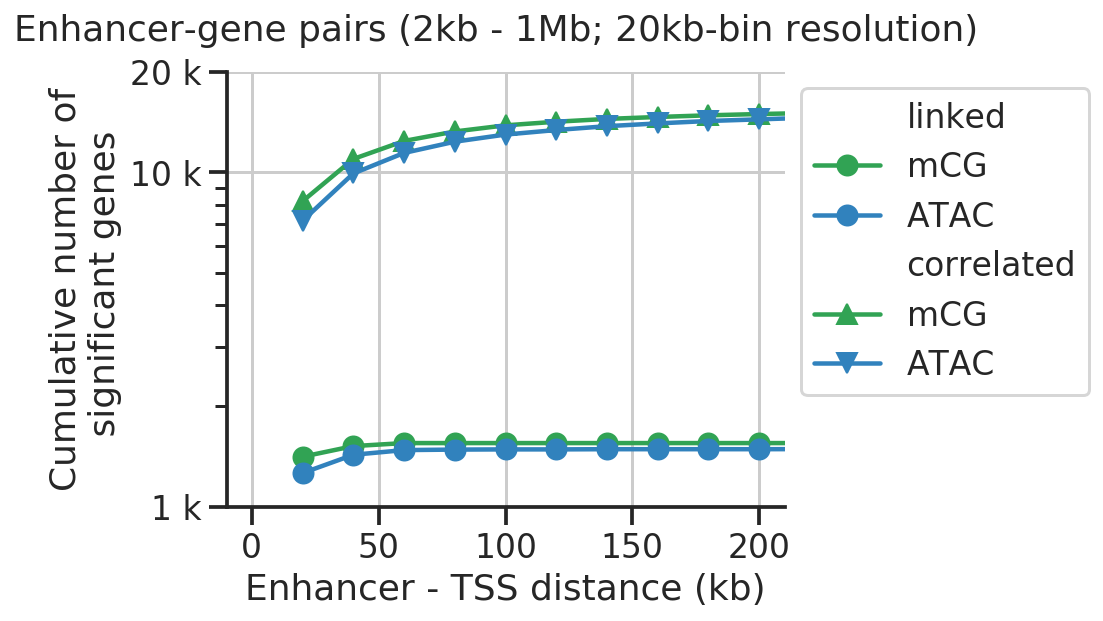

In [23]:
# prep

# one plot
colors = [
    mod_palette_comp['mc'][0], mod_palette_comp['atac'][0], 
    mod_palette_comp['mc'][0], mod_palette_comp['atac'][0], 
    ]
markers = ['o', 'o', '^', 'v']
labels = [
    'mCG linked', 'ATAC linked', 
    'mCG correlated', 'ATAC correlated', 
    ]

# all plots
subplot_cols = [
    'cum_sig_genes',
]
subplot_labels = [
    'Cumulative number of\n significant genes',
    ]
tracks_all = [
    [(df_plot['dist'], df_plot[subplot_col]) for df_plot in df_plots]
    for subplot_col in subplot_cols
]

# plot
fig, axs = plt.subplots(1, 1, figsize=(5,4))
r = EMPTY_RECTANGLE
for i, (ax, tracks_subplot, subplot_label) in enumerate(zip(
        [axs], tracks_all, subplot_labels)):
    for track, color, label, marker in zip(tracks_subplot, colors, labels, markers):
#         if label == ''
#         fillstype = 'full'
#         fillstyle = 'none'
        _x, _y = track
        ax.plot(_x, _y, '-{}'.format(marker), 
                color=color, 
                label=label, 
                markersize=10,
                #  fillstyle='none',
               )
        
    sns.despine(ax=ax)
    ax.set_xlabel('Enhancer - TSS distance (kb)')
    ax.set_ylabel(subplot_label)
    ax.set_xlim(xmin=-10, xmax=210)
    ax.set_ylim(ymin=1000, ymax=2e4)
    ax.set_yscale('log')
    ax.set_yticks([1e3, 1e4, 2e4])
    ax.yaxis.set_major_formatter(mtick.EngFormatter()) 

# work on legends
handles, labels = ax.get_legend_handles_labels()
labels = [label.split(' ')[0] for label in labels]
handles = [r] + handles[:2] + [r] + handles[2:]
labels = ['linked'] + labels[:2] + ['correlated'] + labels[2:]
ax.legend(handles, labels, 
                      bbox_to_anchor=(1,1), loc='upper left', 
                     )
# fig.subplots_adjust(wspace=0.2)
fig.suptitle('Enhancer-gene pairs (2kb - 1Mb; {}kb-bin resolution)'.format(dist_binsize), 
             fontsize=18,
            )
# fig.savefig(output_figures.format('plot_cumsig_gene_vs_dist.pdf'), bbox_inches='tight')
plt.show()

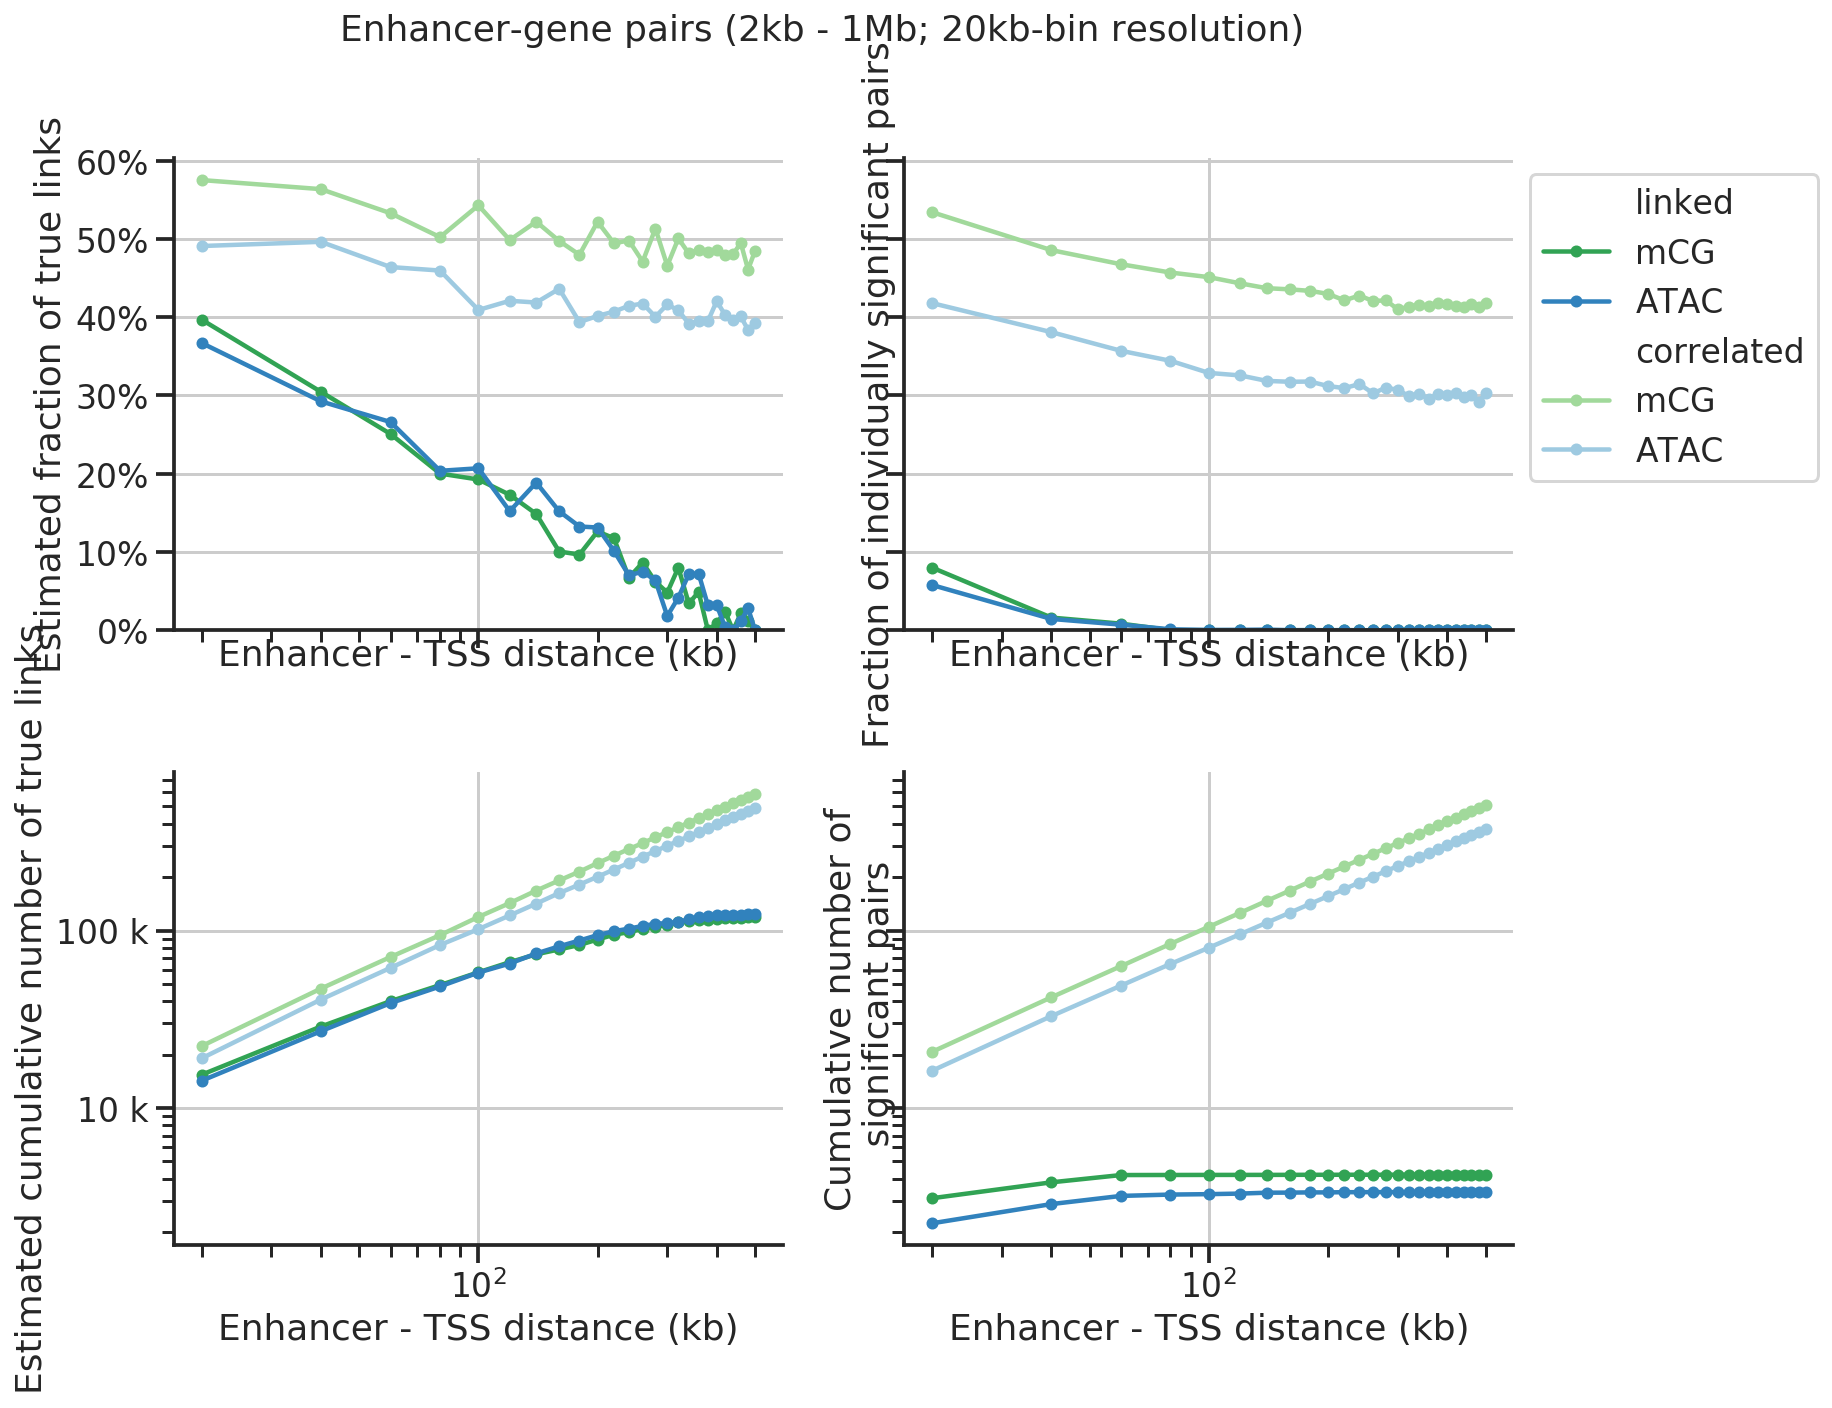

In [24]:
# ... 
# prep

# one plot
colors = [
    mod_palette_comp['mc'][0], mod_palette_comp['atac'][0], 
    mod_palette_comp['mc'][2], mod_palette_comp['atac'][2], 
    ]
labels = [
    'mCG linked', 'ATAC linked', 
    'mCG correlated', 'ATAC correlated', 
    ]

# all plots
subplot_cols = [
    'frac_tp', 
    'sig_frac_tp', 
    
    'num_pos',
    'sig_num_pos',
]
subplot_labels = [
    'Estimated fraction of true links', 
    'Fraction of individually significant pairs', 
    
    'Estimated cumulative number of true links',
    'Cumulative number of\n significant pairs',
    ]
tracks_all = [
    [(df_plot['dist'], df_plot[subplot_cols[0]]) for df_plot in df_plots],
    [(df_plot['dist'], df_plot[subplot_cols[1]]) for df_plot in df_plots],
    [(df_plot['dist'], np.cumsum(df_plot[subplot_cols[2]])) for df_plot in df_plots],
    [(df_plot['dist'], np.cumsum(df_plot[subplot_cols[3]])) for df_plot in df_plots],
]

# plot
fig, axs = plt.subplots(2, 2, figsize=(6*2,5*2), sharex=True, sharey='row',)
r = EMPTY_RECTANGLE
for i, (ax, tracks_subplot, subplot_label) in enumerate(zip(
        axs.flat, tracks_all, subplot_labels)):
    for track, color, label in zip(tracks_subplot, colors, labels):
        _x, _y = track
        ax.plot(_x, _y, '-o', color=color, label=label, markersize=5)
        
    sns.despine(ax=ax)
    ax.set_xlabel('Enhancer - TSS distance (kb)')
    ax.set_ylabel(subplot_label)
    if i in [0, 1]:
        ax.set_ylim(ymin=0)
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 
    if i in [2, 3]:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(mtick.EngFormatter()) 

ax.set_xscale('log')
# work on legends
handles, labels = ax.get_legend_handles_labels()
labels = [label.split(' ')[0] for label in labels]
handles = [r] + handles[:2] + [r] + handles[2:]
labels = ['linked'] + labels[:2] + ['correlated'] + labels[2:]
axs.flat[1].legend(handles, labels, 
                      bbox_to_anchor=(1,1), loc='upper left', 
                     )
fig.subplots_adjust(wspace=0.2, hspace=0.3)
fig.suptitle('Enhancer-gene pairs (2kb - 1Mb; {}kb-bin resolution)'.format(dist_binsize), 
             fontsize=18,
            )
# fig.savefig(output_figures.format('plot_stats_vs_dist_v2.pdf'), bbox_inches='tight')
plt.show()

### Plot corr dist

In [25]:
labels_base = [
          'shuffled cell types',
          'shuffled regions',
          '<500kb',
          '<100kb',
         ] 
subsample_rates = [
                  1,
                  1,
                  1,
                  1,
                 ]


# corr1
labels = [label+' mCG-RNA' for label in labels_base]
corr_tracks = [
       res_corrs['corr_shuff_cells'].values,
       res_corrs['corr_shuff'].values,
       res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
       res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
    
#        corr.flatten(),
#        corr_cis,
      ]
colors = [colors_null[1], colors_null[0], colors_mc[1], colors_mc[0],]
vertical_lines = [
    res_stats['r_th_linked'],
    res_stats['r_th_correlated_left'],
    res_stats['r_th_correlated_right'],
]

# corr2
labels2 = [label+' ATAC-RNA' for label in labels_base]
corr_tracks2 = [
       res2_corrs['corr_shuff_cells'].values,
       res2_corrs['corr_shuff'].values,
       res2_corrs.loc[res2_corrs['dist']<=500*KB, 'corr'].values,
       res2_corrs.loc[res2_corrs['dist']<=100*KB, 'corr'].values,
    
#        corr.flatten(),
#        corr_cis,
      ]
colors2 = [colors_null[1], colors_null[0], colors_atac[1], colors_atac[0],]
vertical_lines2 = [
    ATAC_SIGN*res2_stats['r_th_linked'],
    ATAC_SIGN*res2_stats['r_th_correlated_left'],
    ATAC_SIGN*res2_stats['r_th_correlated_right'],
]

np.random.seed(0)
corr_tracks = [corr_tracks[i][np.random.rand(len(corr_tracks[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks))]
corr_tracks2 = [corr_tracks2[i][np.random.rand(len(corr_tracks2[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks2))]


In [26]:
# plot distribution
def plot_dist_both(
    colors, corr_tracks, labels, vertical_lines, 
    colors2, corr_tracks2, labels2, vertical_lines2, 
    bins,
    subsample_rates,
    fancy=True,
    output='',
    ):
    """
    """
    
    with sns.axes_style('ticks', {'axes.grid': False}):
        fig, axs = plt.subplots(2, 1, figsize=(7*1,4*2), sharex=False)
        for i, ax in enumerate(axs):
            if i == 0:
                _colors = colors
                _corr_tracks = corr_tracks
                _labels = labels
                _vertical_lines = vertical_lines
            elif i == 1:
                _colors = colors2
                _corr_tracks = corr_tracks2
                _labels = labels2
                _vertical_lines = vertical_lines2
            fontsize = ax.xaxis.label.get_fontsize()

            # each line (color) is present in all columns; loop over lines
            ax = axs[i]
            histy_max = 0
            for j, (_x, label, color, subsample_rate) in enumerate(zip(
                    _corr_tracks, _labels, _colors, subsample_rates)):
                # go over columns
                label_comp = '{} ({}, frac={})'.format(label, len(_x), subsample_rate)

                g = ax.hist(_x, bins=bins, 
                            histtype='step', 
                            label=label,
                            color=color, density=True)
                histy, histx, _ = g
                if j == 0:
                    histy0_max = np.max(histy)
                    histx0_max = bins[np.argmax(histy)]
                if j > 0:
                    histy_max = max(histy_max, np.max(histy)) 

            ax.set_ylim([0, 1.3*histy_max])
            if histy0_max > 1.3*histy_max:
                # text
                text_config = {
                    'xy': (histx0_max, 1.3*histy_max), 
                    'ha': 'center', 'va': 'bottom', 
                    'xytext': (0, 0),
                    'textcoords': 'offset points',
                    'fontsize': 0.7*fontsize,
                }
                ax.annotate("{:.2f}".format(histy0_max), **text_config)

            # labels
            if i == 1:
                ax.set_xlabel('Spearman correlation')
            ax.set_ylabel('Density')
            ax.set_xlim([-1, 1])
            sns.despine(ax=ax)

            # line ticks
            ax.grid(which='major', axis='x', linestyle='--')
            ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.2f}'))
            ax.set_xticks(np.sort(np.hstack([[-1, 0, 1], _vertical_lines])))

            # horizontal lines
            lineys = [1.1*histy_max, 1.2*histy_max, 1.2*histy_max]
            linecolors = ['k', 'gray', 'gray']
            texts = ['linked', 'correlated', 'correlated']
            vas = ['top', 'bottom', 'bottom']
            offsets = [(0.2*fontsize, -0.2*fontsize), 
                       (0.2*fontsize, +0.2*fontsize), 
                       (0.2*fontsize, +0.2*fontsize), 
                      ]
            for xcoord, linecolor, liney, text, va, offset in zip(
                _vertical_lines, linecolors, lineys, texts, vas, offsets):
                if xcoord < 0:
                    _x = -1
                    xmin, xmax = -1, xcoord
                    ha = 'left'
                else:
                    _x = 1
                    xmin, xmax = xcoord, 1 
                    ha = 'right'
                # line
                ax.hlines(liney, xmin=xmin, xmax=xmax, color=linecolor, linestyle='-')
                # text
                text_config = {
                    'xy': (_x, liney), 
                    'ha': ha, 'va': va, 
                    'xytext': offset,
                    'textcoords': 'offset points',
                    'fontsize': fontsize,
                }
                ax.annotate(text, **text_config)

        if fancy:
            # title
            axs[0].set_title('mCG-RNA', y=1.1)
            axs[1].set_title('ATAC-RNA', y=1.1)
            
            # combined legend
            r = EMPTY_RECTANGLE
            handles, labels = utils.combine_legends(axs.flat)
            handles = list(handles)
            labels = list(labels)
            # line orders
            _labels = [" ".join(label.split(' ')[:-1])for label in labels]
            _handles = [r] + handles[:4] + [r] + handles[4:]
            # turn it into lines
            _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]
            _labels = ['mCG-RNA'] + ['']*4 + ['ATAC-RNA'] + _labels[4:]
            axs[0].legend(_handles, _labels, ncol=2,
                      bbox_to_anchor=(1,1), loc='upper left')
            
            # text
            text_config = {
                'xy': (1, 0.5*histy_max), 
                'ha': 'right', 'va': 'top', 
                'xytext': (0, 0),
                'textcoords': 'offset points',
                'fontsize': 0.7*fontsize,
            }
            ax.annotate('FDR={:.2f}'.format(fdr_th), **text_config)

        # adjust
        fig.subplots_adjust(hspace=0.5)
#         # savefig
#         if output:
#             fig.savefig(output, bbox_inches='tight')
        plt.show()

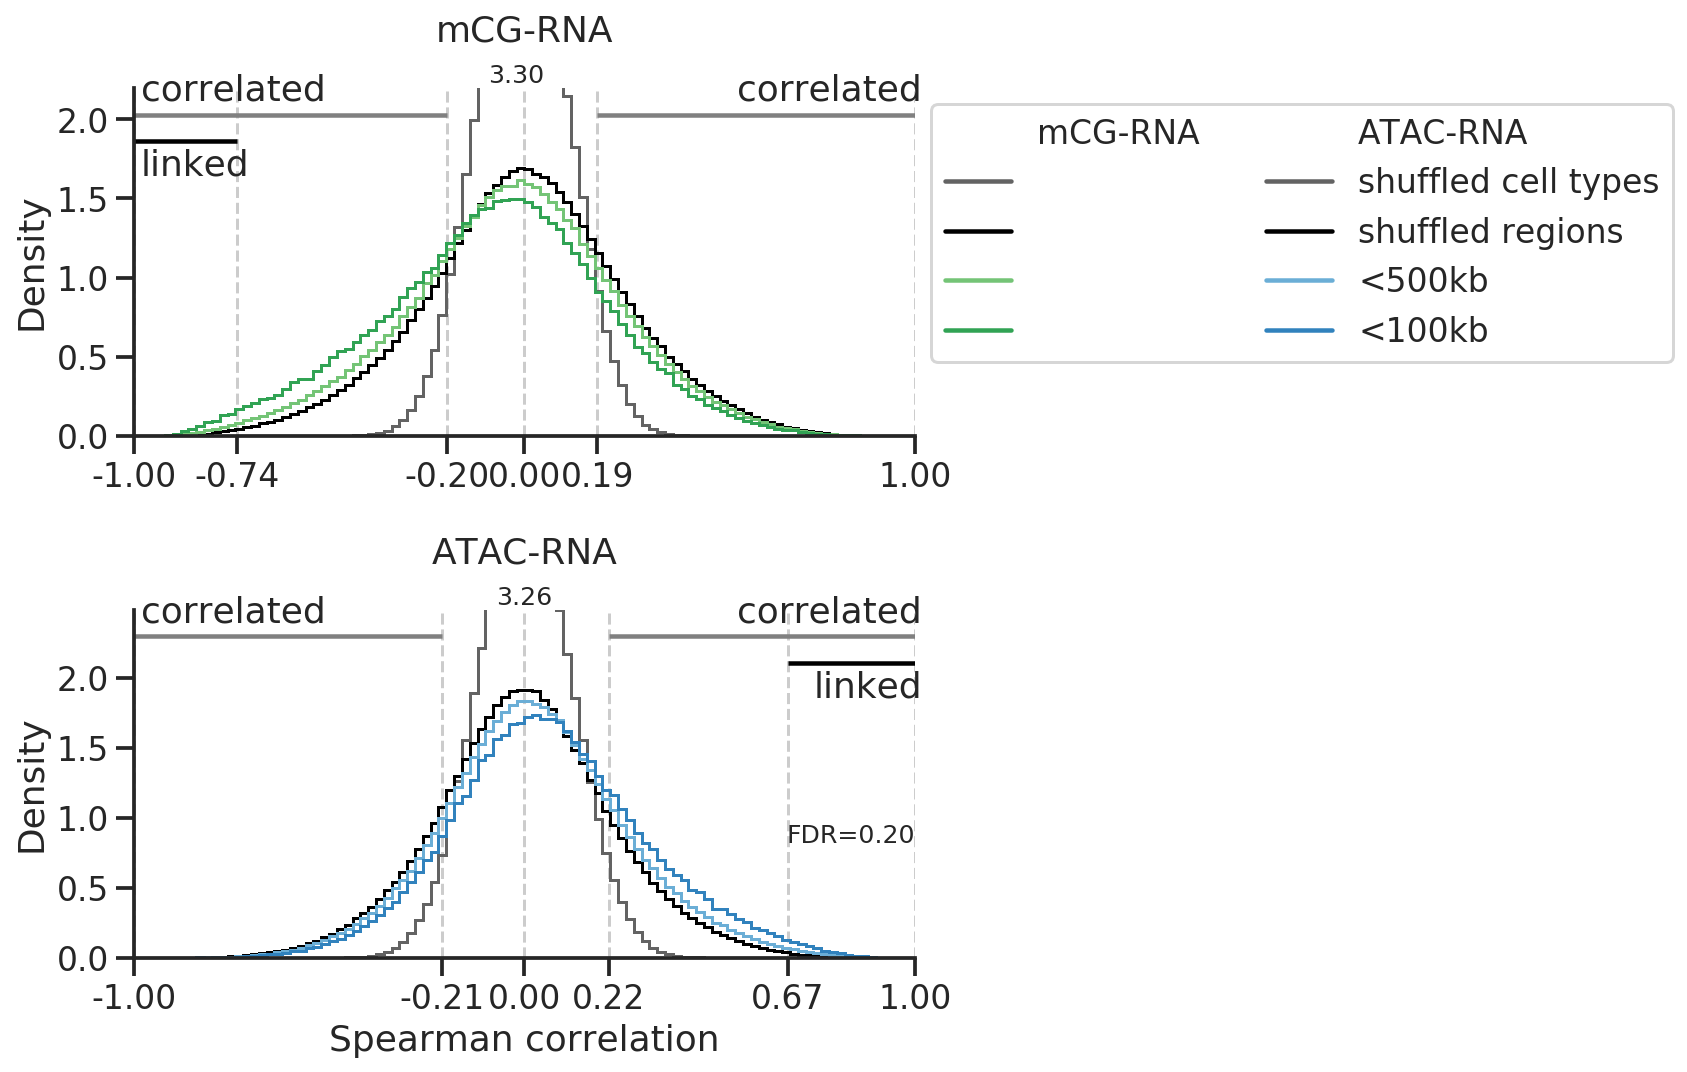

In [27]:
# output = output_figures.format('hist_corr_both.pdf')
# print(output)

bins = np.linspace(-1, 1, 101)

plot_dist_both(
    colors, corr_tracks, labels, vertical_lines, 
    colors2, corr_tracks2, labels2, vertical_lines2, 
    bins,
    subsample_rates,
    fancy=True,
    output=output,
    )

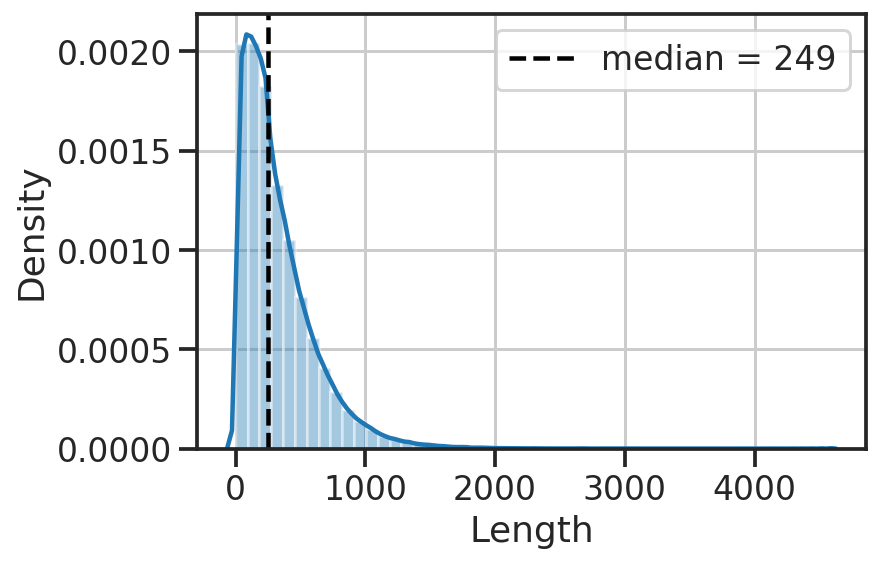

In [28]:
# output = output_figures.format('enh_length_distribution.pdf')
# print(output)

fig, ax = plt.subplots()
sns.distplot(enh_list['length'].values, ax=ax)
med = np.median(enh_list['length'].values)
ax.axvline(med, linestyle='--', color='k', label="median = {:.0f}".format(med))
ax.legend()
ax.set_xlabel('Length')
ax.set_ylabel('Density')
# snmcseq_utils.savefig(fig, output)
plt.show()

### 2D density ATAC vs mC

In [29]:
res_corrs_comb = res_corrs.join(res2_corrs.set_index(['gene', 'enh', 'dist', 'is_in_genebody']), 
                                on=['gene', 'enh', 'dist', 'is_in_genebody'], 
                                lsuffix='_mc', rsuffix='_atac').astype({'enh': int})
res_corrs_comb['corr_both'] = res_corrs_comb['corr_mc'] + (-res_corrs_comb['corr_atac'])
res_corrs_comb = res_corrs_comb.sort_values('corr_both')
print(res_corrs_comb.shape)
res_corrs_comb.head()



(2340530, 11)


,gene,enh,dist,is_in_genebody,corr_mc,corr_shuff_mc,corr_shuff_cells_mc,corr_atac,corr_shuff_atac,corr_shuff_cells_atac,corr_both
507982,ENSMUSG00000023192,226744,56252,False,-0.920444,-0.109574,0.096749,0.884527,0.376357,-0.015394,-1.804971
1197779,ENSMUSG00000034584,221500,506989,False,-0.889738,0.286694,0.061015,0.901520,0.106146,0.040071,-1.791258
974174,ENSMUSG00000030351,192705,14484,False,-0.892332,-0.003058,0.005076,0.883346,0.357301,0.130292,-1.775678
1755831,ENSMUSG00000051456,65586,6188,False,-0.842289,-0.014646,0.018899,0.927495,0.615085,0.074823,-1.769784
1197830,ENSMUSG00000034584,221569,46023,True,-0.943784,0.223576,-0.064880,0.825522,-0.015469,-0.029858,-1.769306


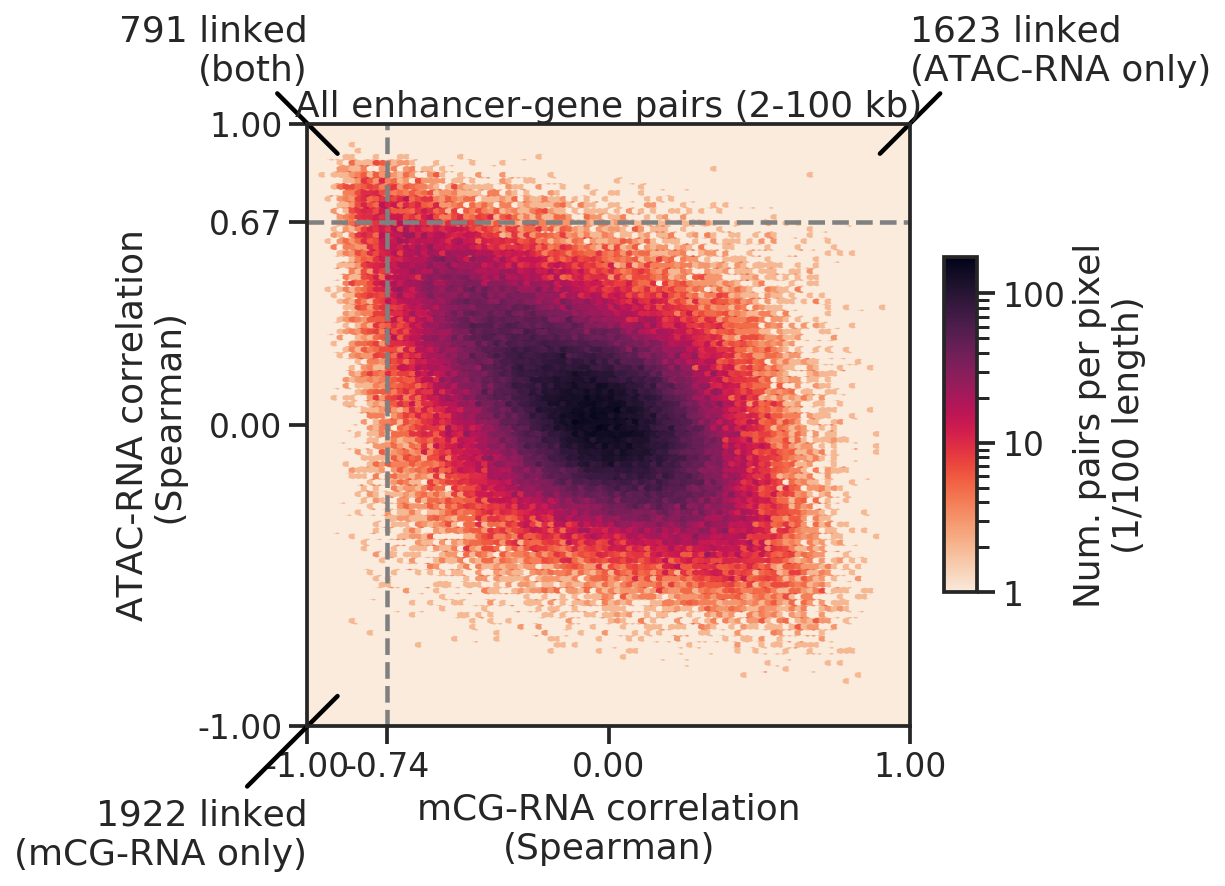

In [30]:
# prep
_table = res_corrs_comb[res_corrs_comb['dist']<1e5]
_x = _table['corr_mc'].values
_y = _table['corr_atac'].values
r_mc, r_atac = res_stats['r_th_linked'], ATAC_SIGN*res2_stats['r_th_linked'] #-0.5, 0.5
# cond_mc = _table['corr_mc'] < r_mc
# cond_atac = _table['corr_atac'] > r_atac

sets = [
    set(res_stats['linked_table'].index.values),
    set(res2_stats['linked_table'].index.values),
]
num_sig_both = len(sets[0] & sets[1])
num_sig_mc = len(sets[0]) - num_sig_both
num_sig_atac = len(sets[1]) - num_sig_both

# plot
fig, ax = plt.subplots(figsize=(6, 6))
g = ax.hexbin(_x, _y,  
              gridsize=(100,100),
              extent=(-1,1,-1,1),
              cmap='rocket_r', 
              bins='log', # log10(i+1)
              rasterized=True,
             )
ax.axhline(r_atac, color='gray', linestyle='--', zorder=2)
ax.axvline(r_mc, color='gray', linestyle='--', zorder=2)
ax.set_aspect('equal')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])  
ax.set_xticks(np.sort([-1, 0, 1, r_mc]))
ax.set_yticks(np.sort([-1, 0, 1, r_atac]))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
ax.set_xlabel('mCG-RNA correlation\n(Spearman)')
ax.set_ylabel('ATAC-RNA correlation\n (Spearman)')
ax.set_title('All enhancer-gene pairs (2-100 kb)', pad=0)

# annotate
ax.annotate("{} linked\n(mCG-RNA only)".format(num_sig_mc), 
            xy=(0,0), xycoords='axes fraction',
            xytext=(0, -2*ax.xaxis.label.get_fontsize()), textcoords='offset points',
            ha='right', va='top',
            fontsize=ax.title.get_fontsize(),
           )
ax.annotate("{} linked\n(ATAC-RNA only)".format(num_sig_atac), 
            xy=(1,1), xycoords='axes fraction',
            xytext=(0, +ax.title.get_fontsize()), textcoords='offset points',
            ha='left', va='bottom',
            fontsize=ax.title.get_fontsize(),
           )
ax.annotate("{} linked\n(both)".format(num_sig_both), 
            xy=(0,1), xycoords='axes fraction',
            xytext=(0, +ax.title.get_fontsize()), textcoords='offset points',
            ha='right', va='bottom',
            fontsize=ax.title.get_fontsize(),
           )

# lines
ax.plot([-1.2,-0.9], [-1.2, -0.9], color='k', clip_on=False)
ax.plot([1.1,0.9], [1.1, 0.9], color='k', clip_on=False)
ax.plot([-1.1,-0.9], [1.1, 0.9], color='k', clip_on=False)


# cbar
cbar = fig.colorbar(g, ax=ax, 
                     fraction=0.05, aspect=10,
                     label='Num. pairs per pixel\n(1/100 length)')
cbar.ax.yaxis.set_major_formatter(mtick.EngFormatter())
# snmcseq_utils.savefig(fig, output_figures.format('scatter_corr_mcrna_atacrna.pdf'))
plt.show()

### Nums enhancer vs nums genes 

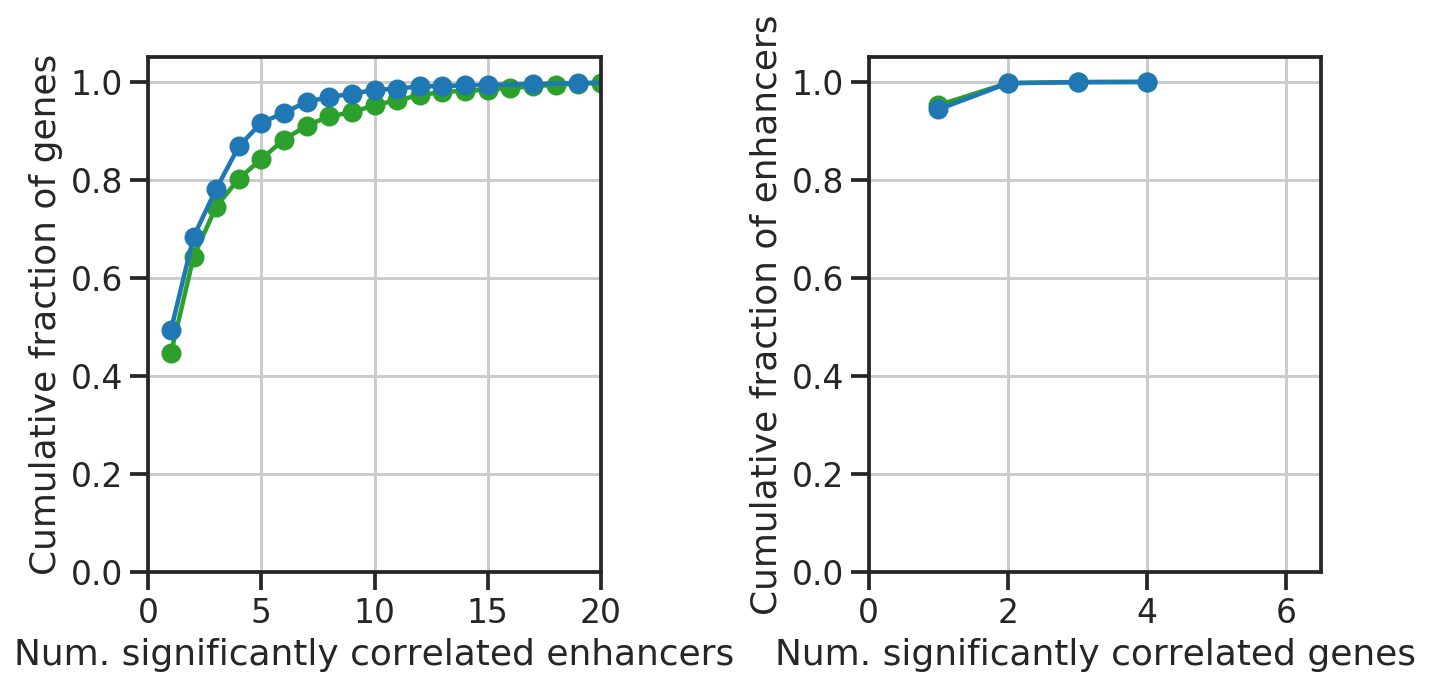

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(5*2,5*1))
ax = axs[0]
for mod, _df in zip(['mc', 'atac'], 
                    [df_nngene, df2_nngene], 
                    ):
    a = _df.groupby('gene').size().sort_values() #.values
    a = a.value_counts().sort_index() #.values
    a = a[a>0]
    a = a/a.sum()
    a = np.cumsum(a)
    
    ax.plot(a.index.values, a.values, '-o', color=mod_palette[mod])
    
ax.set_xlabel('Num. significantly correlated enhancers')
ax.set_ylabel('Cumulative fraction of genes')
ax.set_xlim([0, 20])
ax.set_ylim([0, 1.05])

ax = axs[1]
for mod, _df in zip(['mc', 'atac'], 
                    [df_nngene, df2_nngene], 
                    ):
    a = _df.groupby('enh').size().sort_values() #.values
    a = a.value_counts().sort_index() #.values
    a = a[a>0]
    a = a/a.sum()
    a = np.cumsum(a)
    ax.plot(a.index.values, a.values, '-o', color=mod_palette[mod])
    
ax.set_xlabel('Num. significantly correlated genes')
ax.set_ylabel('Cumulative fraction of enhancers')
ax.set_xlim([0, 6.5])
ax.set_ylim([0, 1.05])



fig.tight_layout()
# fig.savefig(output_figures.format('cdf_gene_enh_num_dist.pdf'), bbox_inches='tight')